In [1]:
import tensorflow as tf

from pod.ai.manual import DQController
from pod.ai.ai_utils import gen_pods
from pod.board import PodBoard
from pod.controller import Controller
from pod.drawer import Drawer
from pod.game import Player
from pod.util import PodState
from vec2 import Vec2
from IPython.display import Image


board = PodBoard([Vec2(5000, 5000), Vec2(12000, 7000)])
controller = DQController(board)
print("OK")

OK


In [ ]:
pods = gen_pods(board.checkpoints[0],10,10,4,3,4)

In [ ]:
for epoch in range(0, 100):
    print("----- Epoch {} -----".format(epoch))
    controller.train_rewards(pods)

In [4]:
for epoch in range(0, 1):
    print("----- Epoch {} -----".format(epoch))
    controller.train_rewards_online(10, 5)

----- Epoch 0 -----
State PodState[pos=(0.000, 0.000) vel=(0.000, 0.000) angle=0.000 laps=0] best action thrust 100.0 target (951.057, 309.017)
    8 --> [[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
State PodState[pos=(0.000, 0.000) vel=(0.000, 0.000) angle=-0.314 laps=0] best action thrust 100.0 target (1000.000, 0.000)
    8 --> [[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
State PodState[pos=(0.000, 0.000) vel=(0.000, 0.000) angle=-0.628 laps=0] best action thrust 100.0 target (951.057, -309.017)
    8 --> [[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
State PodState[pos=(0.000, 0.000) vel=(0.000, 0.000) angle=-0.942 laps=0] best action thrust 100.0 target (809.017, -587.785)
    8 --> [[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
State PodState[pos=(0.000, 0.000) vel=(0.000, 0.000) angle=-1.257 laps=0] best action thrust 0.0 target (0.000, -1000.000)
    0 --> [[1. 0. 0. 0. 0. 0. 0. 0. 0.]]
State PodState[pos=(0.000, 0.000) vel=(0.000, 0.000) angle=-1.571 laps=0] best action thrust 0.0 target (-309.017, -951.057)
    0 --> [[1. 0. 0. 0. 0. 

In [ ]:
from pod.ai.ai_utils import THRUST_VALUES, ANGLE_VALUES
controller.model.save_weights("/src/weights_t{}_a{}".format(THRUST_VALUES, ANGLE_VALUES))

State PodState[pos=(0.000, 0.000) vel=(0.000, 0.000) angle=0.000 laps=0] best action thrust 100.0 target (951.057, 309.017)
    8 --> [[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Best idx of [[0. 0. 0. 0. 0. 0. 0. 0. 1.]] is 8
State PodState[pos=(95.000, 31.000) vel=(80.000, 26.000) angle=0.314 laps=0] best action thrust 100.0 target (904.017, 618.785)
    8 --> [[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Best idx of [[0. 0. 0. 0. 0. 0. 0. 0. 1.]] is 8
State PodState[pos=(256.000, 116.000) vel=(136.000, 72.000) angle=0.628 laps=0] best action thrust 100.0 target (843.785, 925.017)
    8 --> [[0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Best idx of [[0. 0. 0. 0. 0. 0. 0. 0. 1.]] is 8
State PodState[pos=(451.000, 269.000) vel=(165.000, 129.000) angle=0.942 laps=0] best action thrust 100.0 target (1038.785, 1078.017)
    7 --> [[0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Best idx of [[0. 0. 0. 0. 0. 0. 0. 1. 0.]] is 7
State PodState[pos=(675.000, 479.000) vel=(190.000, 178.000) angle=0.942 laps=0] best action thrust 100.0 target (1262.785, 128

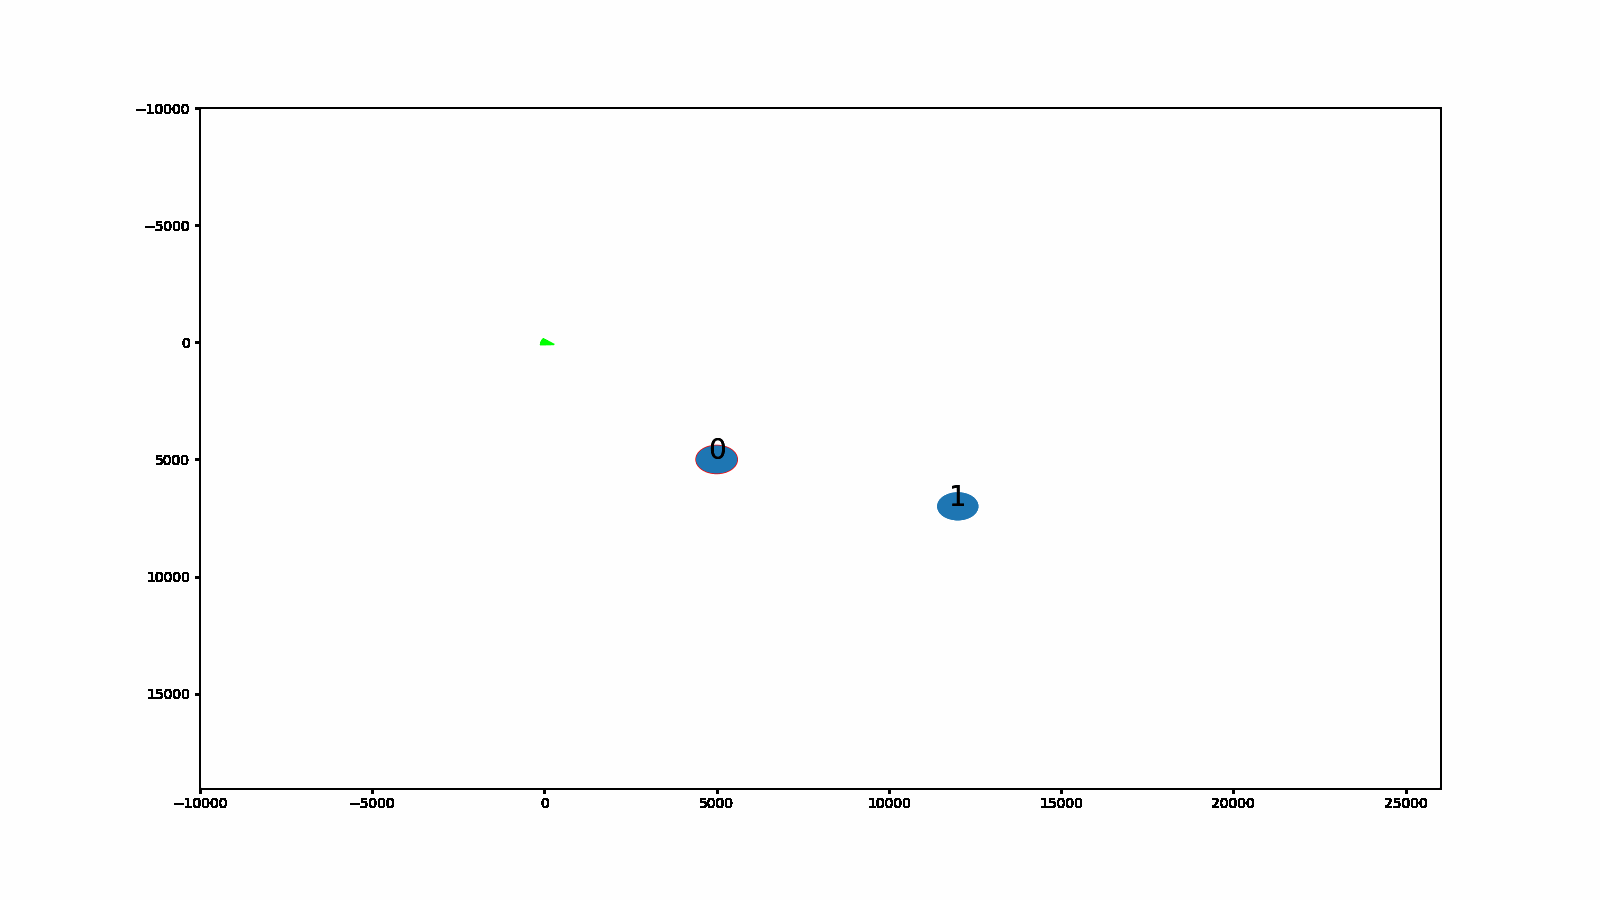

In [3]:
#pod = PodState((board.get_check(0) + board.get_check(1)) * 0.5)
#pod.angle = (board.get_check(0) - board.get_check(1)).angle()
pod = PodState()

player = Player(controller, pod=pod)
drawer = Drawer(board, [player])

file = '/tf/notebooks/pods.gif'
drawer.animate(file, 30)
Image(filename = file)

In [ ]:
import matplotlib.pyplot as plt
from pod.ai.ai_utils import reward, THRUST_VALUES, ANGLE_VALUES, action_to_output
from pod.constants import Constants
from pod.controller import Controller
from pod.game import game_step
from pod.controller import SimpleController, PlayInput, PlayOutput
from pod.board import PodBoard
from vec2 import Vec2
from pod.util import PodState
import numpy as np


world_approx = Constants.world_x() * Constants.world_y()


class RewardController(Controller):
    def __init__(self, board: PodBoard):
        self.board = board

    def play(self, pi: PlayInput) -> PlayOutput:
        rewards = []
        pod = PodState()
        for action in range(0, THRUST_VALUES * ANGLE_VALUES):
            pod.pos = pi.pos
            pod.angle = pi.angle
            pod.nextCheckId = pi.nextCheckId
            pod.vel = pi.vel
            po = action_to_output(action, pod.angle, pod.pos)
            game_step(self.board, pod, po, pod)
            rewards.append(reward(pod, self.board))

        best_action = np.argmax(rewards)
        best_po = action_to_output(best_action, pi.angle, pi.pos)
        dist_sq_to_check = (self.board.checkpoints[pi.nextCheckId] - pi.pos).square_length()
        dist_reward = max((world_approx - dist_sq_to_check) / world_approx, 0)
        print("rewards: {}".format(rewards))
        return best_po



test_board = PodBoard([Vec2(6000, 4000), Vec2(12000, 7000)])
#c = SimpleController()
c = RewardController(test_board)

pod = PodState(Vec2(0,0))
x_values = []
y_values = []
turns = 0
#while pod.laps < 2:
while turns < 100:
    x_values.append(pod.turns)
    y_values.append(reward(pod, test_board))
    pi = PlayInput(pod, test_board)
    play = c.play(pi)
    game_step(test_board, pod, play, pod)
    turns += 1

plt.plot(x_values, y_values)
plt.xlabel('turns')
plt.ylabel('reward')

plt.show()

In [ ]:
from pod.drawer import Drawer
from pod.game import Player
from IPython.display import Image

board = PodBoard([Vec2(10000, 6000), Vec2(1000, 1000)])
cnt = RewardController(board)
player = Player(cnt, PodState(Vec2(-1000, -1000)))
drawer = Drawer(board, [player])

file = '/tf/notebooks/pods.gif'
drawer.animate(file, 200)
Image(filename = file)

In [ ]:
from pod.ai.ai_utils import reward, THRUST_VALUES, ANGLE_VALUES, action_to_play, action_to_output
from vec2 import Vec2, ORIGIN


for action in range(0, THRUST_VALUES * ANGLE_VALUES):
    print("Action {} ---> play {}".format(action, action_to_play(action)))
    print("   ---> output {}".format(action_to_output(action, 0, ORIGIN)))